In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime, date
import time

In [3]:
# sanity check get total number of fatalities
df = pd.read_csv('../FARS2018NationalCSV/Person.CSV', encoding="ISO-8859-1")
df = df.loc[df['INJ_SEV'] == 4]
print(len(df))
df.head(5)
df = pd.read_csv('../FARS2018NationalCSV/accident.CSV', encoding="ISO-8859-1")
print(len(df))

/var/folders/rv/4pnymp6j7bd30dklzsj4ykr40000gn/T/ipykernel_79137/2204402832.py:2: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../FARS2018NationalCSV/Person.CSV', encoding="ISO-8859-1")


36835
33919


### Get fatalities

In [12]:
# get fatalities of only when there are multiple people in vehicle
df1 = pd.read_csv('../FARS2018NationalCSV/vehicle.csv', encoding="ISO-8859-1")
print(len(df1))
df1 = df1.loc[df1['NUMOCCS'] > 1]
print(len(df1))
df2 = pd.read_csv('../FARS2018NationalCSV/Person.CSV', encoding="ISO-8859-1")
df2 = df2[df2['ST_CASE'].isin(df1['ST_CASE'].values.tolist())]
df = df2.loc[df2['INJ_SEV'] == 4]
print(df['INJ_SEV'][0:20])
print(df['DOA'][0:20]) # dead on arrival
print(len(df))

/var/folders/rv/4pnymp6j7bd30dklzsj4ykr40000gn/T/ipykernel_79137/3238274895.py:2: DtypeWarning: Columns (14,56,58,193,195) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv('../FARS2018NationalCSV/vehicle.csv', encoding="ISO-8859-1")


52286
16120
1     4
2     4
6     4
21    4
26    4
27    4
33    4
34    4
38    4
42    4
45    4
50    4
56    4
61    4
67    4
70    4
73    4
77    4
86    4
90    4
Name: INJ_SEV, dtype: int64
1     7
2     7
6     7
21    7
26    7
27    7
33    0
34    7
38    0
42    7
45    0
50    7
56    0
61    0
67    7
70    7
73    7
77    7
86    7
90    0
Name: DOA, dtype: int64
16395


/var/folders/rv/4pnymp6j7bd30dklzsj4ykr40000gn/T/ipykernel_79137/3238274895.py:6: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv('../FARS2018NationalCSV/Person.CSV', encoding="ISO-8859-1")


## Graphs about the dataset
#### Graphs about time of crashes and time of death

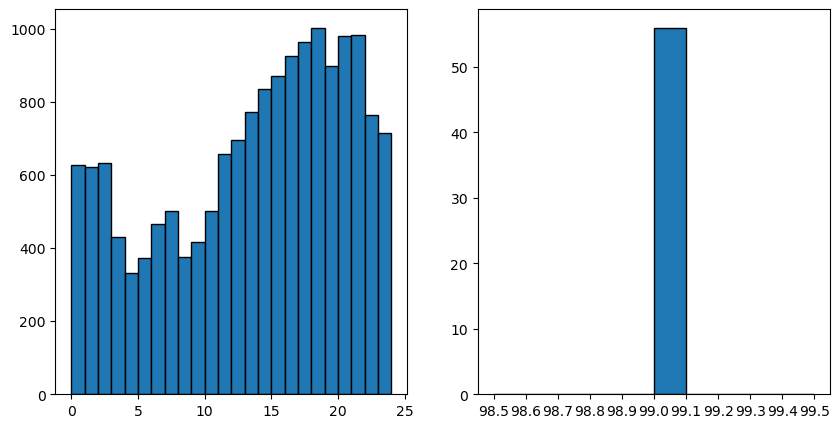

In [4]:
# create graph to display time of day crash occurred
df_hour = df['HOUR']
df_hour = df_hour.loc[df_hour <= 24] # dropout unknown crash times to get cleaner histogram

df_unknown_hour = df['HOUR']
df_unknown_hour = df_unknown_hour.loc[df_unknown_hour > 24]

fig,ax = plt.subplots(1,2, figsize=(10,5))
ax[0].hist(df_hour, range(0,25),edgecolor = "black")
_,bins,_ = ax[1].hist(df_unknown_hour, edgecolor="black")
ax[1].set_xticks(bins);

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]


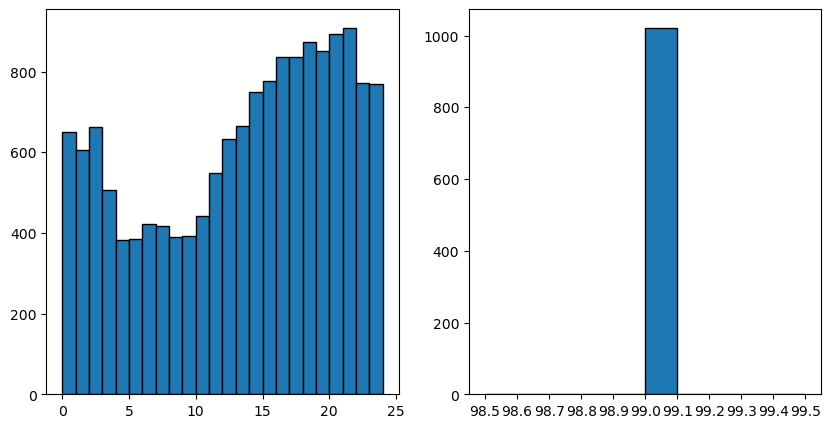

In [5]:
# graph of time of death -- including deaths on arrival
df_hour = df['DEATH_HR']
df_hour = df_hour.loc[df_hour <= 24] # dropout unknown crash times to get cleaner histogram

df_unknown_hour = df['DEATH_HR']
df_unknown_hour = df_unknown_hour.loc[df_unknown_hour > 24]

fig,ax = plt.subplots(1,2, figsize=(10,5))
_,bins,_ = ax[0].hist(df_hour, range(0,25),edgecolor = "black")
print(bins)
_,bins,_ = ax[1].hist(df_unknown_hour, edgecolor="black")
ax[1].set_xticks(bins);

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]


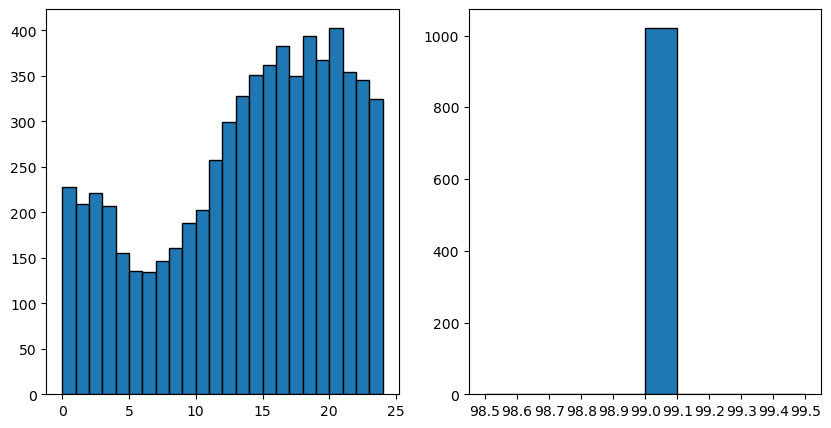

In [6]:
# graph of time of death -- excluding deaths on arrival
df_hour = df.loc[df['DOA'] != 7]
df_hour = df_hour['DEATH_HR']
df_hour = df_hour.loc[df_hour <= 24] # dropout unknown crash times to get cleaner histogram

df_unknown_hour = df.loc[df['DOA'] != 7]
df_unknown_hour = df['DEATH_HR']
df_unknown_hour = df_unknown_hour.loc[df_unknown_hour > 24]

fig,ax = plt.subplots(1,2, figsize=(10,5))
_,bins,_ = ax[0].hist(df_hour, range(0,25),edgecolor = "black")
print(bins)
_,bins,_ = ax[1].hist(df_unknown_hour, edgecolor="black")
ax[1].set_xticks(bins);

Note:
0 -- made it to hospital 6936.0 
7 -- dead on arrival 9344.0 
8 -- died in trasit 107.0 
9 -- Unknown 8.0


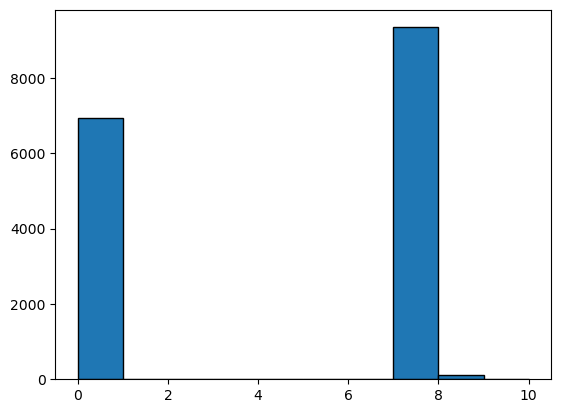

In [7]:
# graph of Dead on Arrival
arr = plt.hist(df['DOA'], range(0,11),edgecolor="black")
arr = arr[0]
print('Note:\n0 -- made it to hospital', arr[0], '\n7 -- dead on arrival', arr[7], '\n8 -- died in transit', arr[8], '\n9 -- Unknown', arr[9])

#### ejection stats

[ 0  1  2  3  4  5  6  7  8  9 10]


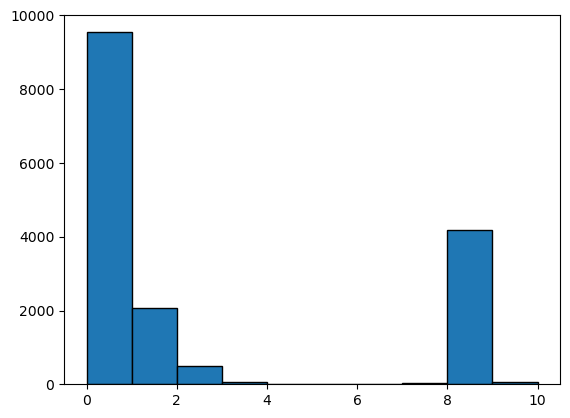

In [8]:
# 
df_ejected = df['EJECTION']
_,bins,_ = plt.hist(df_ejected, range(0,11),edgecolor = "black")
print(bins)

### Print out some statistics about the dataset

Look at individual statistics and see what can be used.

> Need to narrow down some of the variables

##### somethings to possible look at
- the time of survival for ejections
- how likely is someone to survive if they are ejected
- heatmap that shows DOA, ejections, rollovers

mean:  0.9754757700608201
std:  3.3108897500136316
var:  10.961990936745327


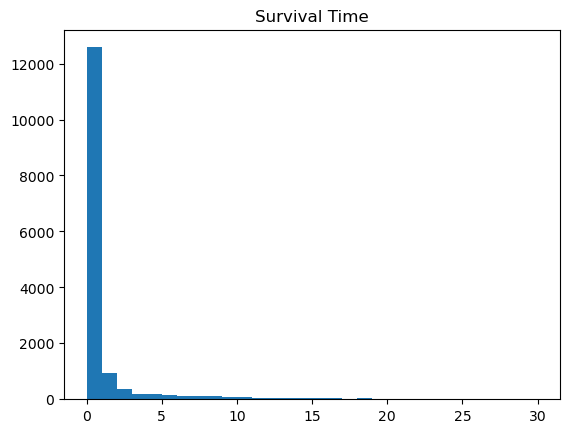

In [27]:
# cell is used to calculate survival time of all occurrances
# structure of time MMDDHHMM
df_crash_times = df.loc[df['HOUR'] != 99] # drop unknown times
df_crash_times = df_crash_times.loc[(df_crash_times['DEATH_HR'] != 99) & (df_crash_times['DEATH_MO'] != 99) & (df_crash_times['DEATH_MN'] != 99)]
# df_crash_times = pd.DataFrame(crash_dict)
df_crash_times['combined'] = "2018 " + df_crash_times['MONTH'].astype(str) + " " + df_crash_times['DAY'].astype(str) + " 2018 " + df_crash_times['DEATH_MO'].astype(str) + " " + df_crash_times['DEATH_DA'].astype(str)# + " " + df_crash_times['HOUR'].astype(str) + " " + df_crash_times['MINUTE'].astype(str)

crash_times = []
day_diff = []
for i in df_crash_times['combined']:
    date_split = i.split()
    day_diff.append((date(2018, int(date_split[4]), int(date_split[5])) - date(2018, int(date_split[1]), int(date_split[2]))).days)
#     crash_times.append(datetime.timestamp(datetime.strptime(i, "%Y %m %d %H %M")))
day_diff = np.array(day_diff)
day_diff = day_diff[day_diff >= 0]
"""
df_crash_times['combined_death'] = "2018 " + df_crash_times['DEATH_MO'].astype(str) + " " + df_crash_times['DEATH_DA'].astype(str) + " " + df_crash_times['DEATH_HR'].astype(str) + " " + df_crash_times['DEATH_MN'].astype(str)
death_times = []
for i in df_crash_times['combined_death']:
    death_times.append(datetime.timestamp(datetime.strptime(i, "%Y %m %d %H %M")))

diff_times = []
for i in range(0, len(death_times)):
    print(death_times[i])
    diff_times.append(date(death_times[i]) - date(crash_times[i]))
"""
plt.hist(day_diff, 30)
plt.title("Survival Time")
print("mean: ", np.mean(day_diff))
print("std: ", np.std(day_diff))
print("var: ", np.var(day_diff))

In [10]:
# average age 
df['AGE'].loc[df['AGE'] < 125].describe()

count    16363.000000
mean        42.556194
std         21.700345
min          0.000000
25%         24.000000
50%         39.000000
75%         59.000000
max        105.000000
Name: AGE, dtype: float64

Note:
0 -- made it to hospital
7 -- dead on arrival
8 -- died in trasit


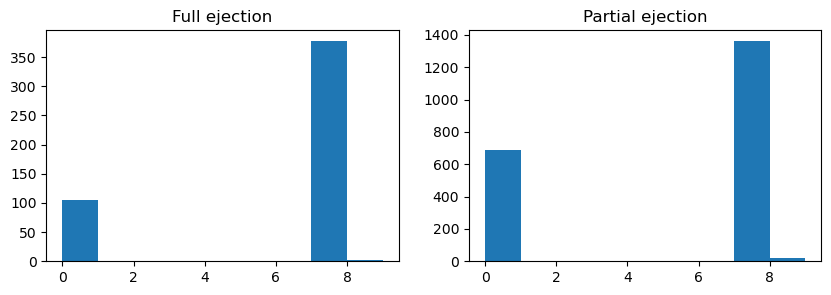

In [11]:
# amount of people who died at the scene after ejection
df_fulleject = df.loc[(df['EJECTION'] == 2) & (df['DOA'] != 9)]
fig,ax = plt.subplots(1,2, figsize=(10,3))
print('Note:\n0 -- made it to hospital\n7 -- dead on arrival\n8 -- died in trasit')
ax[0].hist(df_fulleject['DOA'], range(0,10));
ax[0].title.set_text('Full ejection')
df_fulleject = df.loc[(df['EJECTION'] == 1) & (df['DOA'] != 9)]
ax[1].hist(df_fulleject['DOA'], range(0,10));
ax[1].title.set_text('Partial ejection')

x-axis:
0 -- made it to hospital
7 -- dead on arrival
8 -- died in trasit


y-axis:



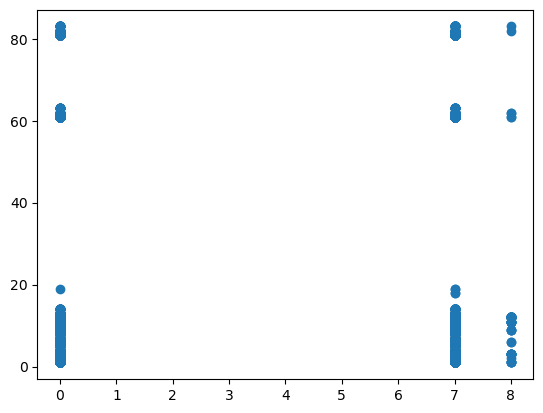

In [12]:
# display simple stats about collision location and death rate
df_collision = df.loc[(df['IMPACT1'] != 0) & (df['IMPACT1'] != np.NaN) & (df['IMPACT1'] != 99) & (df['IMPACT1'] != 98) & (df['DOA'] != 9)]
print('x-axis:\n0 -- made it to hospital\n7 -- dead on arrival\n8 -- died in trasit\n')
print('\ny-axis:\n')
plt.scatter(df_collision['DOA'],df_collision['IMPACT1'])

## Get severely injured occupants of vehicles but survived

In [13]:
# get fatalities of only when there are multiple people in vehicle
df1 = pd.read_csv('../FARS2018NationalCSV/vehicle.csv', encoding="ISO-8859-1")
df1 = df1.loc[df1['NUMOCCS'] > 1]
df2 = pd.read_csv('../FARS2018NationalCSV/Person.CSV', encoding="ISO-8859-1")
df2 = df2[df2['ST_CASE'].isin(df1['ST_CASE'].values.tolist())]
df_survived = df2.loc[(df2['INJ_SEV'] == 2) | (df2['INJ_SEV'] == 3) | (df2['INJ_SEV'] == 0) | (df2['INJ_SEV'] == 1)]
print(df_survived['ST_CASE'][0:20])
print(df_survived['INJ_SEV'][0:20])
print(df_survived['DOA'][0:20]) # dead on arrival
print(len(df_survived))

/var/folders/rv/4pnymp6j7bd30dklzsj4ykr40000gn/T/ipykernel_72075/569102029.py:2: DtypeWarning: Columns (14,56,58,193,195) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv('../FARS2018NationalCSV/vehicle.csv', encoding="ISO-8859-1")


5     10004
22    10011
23    10011
24    10011
28    10013
29    10013
32    10015
35    10016
39    10018
40    10018
41    10019
46    10021
47    10021
48    10021
49    10021
51    10022
52    10022
53    10022
57    10024
58    10024
Name: ST_CASE, dtype: int64
5     0
22    3
23    3
24    3
28    2
29    1
32    3
35    3
39    1
40    0
41    3
46    0
47    0
48    0
49    0
51    3
52    3
53    3
57    3
58    2
Name: INJ_SEV, dtype: int64
5     0
22    0
23    0
24    0
28    0
29    0
32    0
35    0
39    0
40    0
41    0
46    0
47    0
48    0
49    0
51    0
52    0
53    0
57    0
58    0
Name: DOA, dtype: int64
33654


/var/folders/rv/4pnymp6j7bd30dklzsj4ykr40000gn/T/ipykernel_72075/569102029.py:4: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv('../FARS2018NationalCSV/Person.CSV', encoding="ISO-8859-1")


### Data Notes

Things that might be helpful to use as variable

- collision location
- rollover
- ejection
- speed if available
- airbag deployed or not
- seatbelt usage


### Possible Methods

There are a couple approaches that could be taken for survival time. The response variable will be the survival time which can be found in plots above

- split into bins
 - 4 bins of ≈7
 - use 31 bins
 
#### Regression methods

each of these methods will be continuous variable

- neural network -- most likely will use
- straight linear regression

#### Feature selection

- sklearn feature selection
- wrapper method
- filter method

### Explainable ML tools

- shap


In [ ]:
from sklearn import neural_network, feature_selection